# Dataloaders and such

Gettig the data ready - luckily it's fairly easy thanks to fastai.

Import everything in FastAI vision, of course, this is a bad idea in production code.

In [1]:
from fastai.vision.all import *
import pandas as pd
import timm
import warnings 
warnings.filterwarnings('ignore')

Seed everything! reproducibility is very important

In [2]:
 def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

In [3]:
random_seed(2021,True) #i'm using seed 2021

Bring in the Dataset csv files using pandas library, pandas came when I imported everything in Fastai.vision

In [4]:
train = pd.read_csv('Train.csv')
train.head()

,Image_ID,Target
0,ID_0073qfb8,0
1,ID_00gy3vH2,1
2,ID_00uB3UFr,0
3,ID_012xZpNw,1
4,ID_014GgMRb,1


Check distribution, normally, you should do this with some visualizations, for this hack I was too focused on moving fast. I suggest you give this a try.

In [15]:
train.Target.value_counts()

1    3771
0    3229
Name: Target, dtype: int64

We're classifying road segments, you might want to check out what a single image looks like.

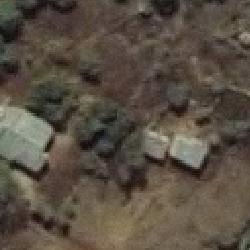

In [16]:
Image.open('Images/ID_0073qfb8.tif') # View one image and check the files are present

###### Load Data into FastAI

Use Fastai Data Api block to load the dataset, note that I used a stratified split for train and validation

In [5]:
road = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    splitter=TrainTestSplitter(0.1, stratify=train["Target"]),
  get_x = ColReader(0),
    get_y=ColReader(1))

The train set contains image IDs, for FastAI to get the image I did some manipulations to complete it as a path. There are better ways to do this, however, they may not come to you in the heat of the hack, lol.

In [6]:
train.Image_ID = ["Images/"+i+".tif" for i in train.Image_ID]

Quick head view.

In [7]:
train.head()

,Image_ID,Target
0,Images/ID_0073qfb8.tif,0
1,Images/ID_00gy3vH2.tif,1
2,Images/ID_00uB3UFr.tif,0
3,Images/ID_012xZpNw.tif,1
4,Images/ID_014GgMRb.tif,1


Next here, we create the dataloader, I used a very small batch size here, so that I could make the gradient steps move smaller, hence get that sweet spot for a good test & valid accuracy.

In [8]:
dls = road.dataloaders(train, bs=8)

Check out a minibatch before we proceed.

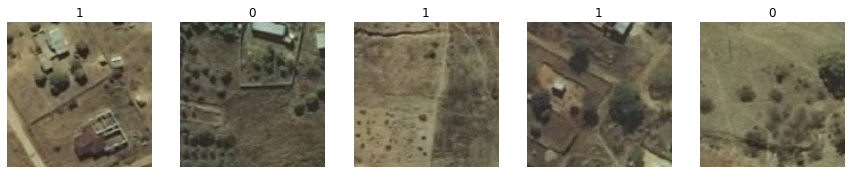

In [9]:
dls.train.show_batch(max_n=5, nrows=1)

# Training the Model

###### Bring in models from Pytorch's pretrained bunch of models

Actually, we could have achieved this without having to pull from pytorch, Personally I wanted to check out the performance of mobilenet, and a bunch of others just by switching the name alone. You can add it to your bag of tricks! It's a smart move.

So I picked the Densenet161 for my final solution, and used error_rate to measure the model performance. Don't be confused, I cut the last layer which contains the imagenet classes

In [10]:
import torchvision.models as models
learn = cnn_learner(dls, models.densenet161, cut=-1,metrics=error_rate)
learn.lr_find()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to C:\Users\HP/.cache\torch\hub\checkpoints\densenet161-8d451a50.pth
100%|███████████████████████████████████████████████████████████████████████████████| 110M/110M [01:50<00:00, 1.04MB/s]


###### Train the model

I only trained the model for 3 epochs, notice how magnificiently well the error rate reduced during the 3rd epoch, It's amazing!

###### Don't forget to mixup!!

So now you've noticed we didn't do any data augumentation while creating the data loader, that's because I intended to land it with mixup. What mixup basically does is to combine pictures together, it could be same classes or even different classes and learn to identify by how much different they are, this is a good idea for road segmentation where the images look very much alike, you'll need to hold both images side by side to spot the difference.

In [11]:
learn.fine_tune(3, cbs=MixUp(0.2))

epoch,train_loss,valid_loss,error_rate,time


KeyboardInterrupt: 

Yeah! I also smiled when I saw the error rate, 0.10..., Infact I didn't check out what would have happened if I trained longer, I suggest you could try that out and see what happens.

# Making and Saving Predictions

We make a test dataloader, get the predicted probabilities and shape them into the format Zindi wants. I hope this sort of makes sense :)

In [ ]:
# Load the test data
test = pd.read_csv('Test.csv')
test.head(3)

In [ ]:
# Check format
ss = test.copy()#pd.read_csv('/content/drive/MyDrive/machine_learning_stories/Road_segSampleSubmission.csv')
ss.head(3)

###### Use TTA

It's a good idea to use TTA, this helps to improve score.

In [ ]:
# Make a test dataloader and get predictions
tdl = learn.dls.test_dl(test['Image_ID'].map(lambda s: 'Images/'+s+'.tif').values)
test_preds_tta, test_labels_tta = learn.tta(dl=tdl)
preds = [p[1] for p in test_preds_tta.numpy()]

Check Out a single Prediction

In [27]:
preds[0]

0.07387775

###### Make your submission

In [ ]:
# Store the predicted probabilities (we want P(Target=1))
test['Target'] =preds #[float(p[1]) for p in preds[0]]
test.head()

Download your csv file and submit to Zindi

In [ ]:
# Create submission DataFrame
submission = pd.DataFrame({"Image_ID": test["Image_ID"],
                           "Target": test['Target']})
submission.head()

In [ ]:
submission.to_csv('submission_1.csv', index=False)

In [29]:
name = "3 ep batch8 dense161 with mixup and tta.csv"
test.to_csv(name, index=False)
from google.colab import files
files.download(name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###### The End